# A/B–тестирование

Одной из основных задач аналитика является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## 1.1 Входные данные

В качестве входных данных имеем 4 csv-файла:

* [groups.csv](https://disk.yandex.ru/d/58Us0DWOzuWAjg) - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* [groups_add.csv](https://disk.yandex.ru/d/3aARY-P9pfaksg) - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* [active_studs.csv](https://disk.yandex.ru/d/prbgU-rZpiXVYg) - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* [checks.csv](https://disk.yandex.ru/d/84hTmELphW2sqQ) - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Подгружаем необходимые библиотеки:

In [1]:
import pandas as pd
import requests 
from urllib.parse import urlencode 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import numpy as np
from tqdm.auto import tqdm

from scipy import stats
import pandahouse as ph

D:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Напрямую считать файл по ссылке не удается, добавим некоторый функционал, для удобства обернем в функцию:

In [2]:
def get_yandex(link: str) -> str:
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # получаем url 
    final_url = base_url + urlencode(dict(public_key = link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

Теперь получаем данные:

In [3]:
groups       = pd.read_csv(get_yandex('https://disk.yandex.ru/d/58Us0DWOzuWAjg'), sep=';')
groups_add   = pd.read_csv(get_yandex('https://disk.yandex.ru/d/3aARY-P9pfaksg'), sep=',')
active_studs = pd.read_csv(get_yandex('https://disk.yandex.ru/d/prbgU-rZpiXVYg'), sep=';')
checks       = pd.read_csv(get_yandex('https://disk.yandex.ru/d/84hTmELphW2sqQ'), sep=';')

Смотрим на данные, которые получили:

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
groups.shape[0]

74484

In [7]:
groups.nunique()

id     74484
grp        2
dtype: int64

Значит, все ```id``` уникальны, в ```grp``` представлены два значения. Проверим на пустые значения:

In [8]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Аналогично, ```groups_add```:

In [10]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [12]:
groups_add.shape[0]

92

In [13]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [14]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

```checks```:

In [16]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [18]:
checks.shape[0]

541

In [19]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [20]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [21]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

```active_studs```:

In [22]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [23]:
active_studs.shape[0]

8341

In [24]:
active_studs.nunique()

student_id    8341
dtype: int64

In [25]:
active_studs.isna().sum()

student_id    0
dtype: int64

В ```groups``` хранится информация о принадлежности пользователя к контрольной или экспериментальной группе, а в ```groups_add``` - дополнительные данные спустя 2 дня. Соединим данные c первым датафреймом:

In [26]:
groups_all = pd.concat([groups, groups_add], axis=0)

In [27]:
groups_all.shape[0]

74576

Теперь в полученном датафрейме хранится информация о всех пользователях, участвующих в эксперименте, но необходимо определить, сколько из них были активны:

In [28]:
groups_all.loc[groups_all.id.isin(active_studs.student_id)].shape[0]

8341

In [29]:
groups_all.loc[groups_all.id.isin(active_studs.student_id)].nunique()

id     8341
grp       2
dtype: int64

Cоответственно, только 8341 пользователь был активен во время эксперимента. Сохраним информацию о них в отдельный датафрейм:

In [30]:
active_from_groups = groups_all.loc[groups_all.id.isin(active_studs.student_id)]

В ```checks``` информация об оплатах пользователей в дни проведения эксперимента:

In [31]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [32]:
checks.student_id.nunique(), active_from_groups.id.nunique()

(541, 8341)

Количество пользователей значительно превышает количество оплат. Из пользователей, участвующих в эксперименте, совершили оплату:  

In [33]:
active_from_groups.loc[active_from_groups.id.isin(checks.student_id)].shape[0]

392

C другой стороны, остались пользователи, которые совершили оплату во время эксперимента, но при этом не участвовали в эксперименте:

In [34]:
checks.student_id.nunique() - active_from_groups.loc[active_from_groups.id.isin(checks.student_id)].shape[0]

149

Иначе:

In [35]:
checks.loc[~checks.student_id.isin(active_from_groups.id)].shape[0]

149

In [36]:
groups_all.loc[groups_all.id.isin(checks.loc[~checks.student_id.isin(active_from_groups.id)].student_id)].shape[0]

149

В итоге сложилась ситуация, когда во время эксперимента были 149 оплаты, однако ```id``` пользователей, кто оплатил, нет среди активных. Это могло возникнуть как в следствие ошибок при записи данных, так и при ошибках во время оплаты, ошибках во время формирования выборки для эксперимента. Если бы в данных была информация о статусе оплаты с соответстующими ```timestamp```, картина стала бы более ясной. 

Для дальнейшей работы с данными отберем пользователей, которые включены в эксперимент и активны во время эксперимента, чтобы дать наиболее точную оценку эксперимента и минимизировать количество ошибок.

Собираем все в один датафрейм, используем ```left join```:

In [37]:
checks.columns = ['id', 'rev']
df = active_from_groups.merge(checks, how='left', on='id')

In [38]:
df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN


In [39]:
df.shape

(8341, 3)

Посчитаем количество пустых значений после джойна:

In [40]:
df.isna().sum()

id        0
grp       0
rev    7949
dtype: int64

In [41]:
df.loc[df.rev.isna()].grp.value_counts()

B    6489
A    1460
Name: grp, dtype: int64

In [42]:
df.loc[df.rev.notna()].grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

Видно сразу, что отличается размер выборок, а так же в каждой группе малое количество пользователей, которые совершили оплату.

Для анализа будем использовать следующие метрики:

* конверсия в покупку 
* ARPPU
* ARPU

Начнем с конверсии. Для подсчета необходимо найти отношение количества оплативших пользователей на количество пользователей в группе:

In [43]:
metrics = df.groupby('grp', as_index=False) \
                 .agg({'id': 'count'}) \
                 .merge(df.query('rev > 0') \
                          .groupby('grp', as_index=False) \
                          .agg({'id': 'count'}), on='grp') \
                 .rename(columns={'grp': 'group', 
                                  'id_x': 'users', 
                                  'id_y': 'purchases'})
metrics['CR'] = metrics.purchases / metrics.users
metrics

,group,users,purchases,CR
0,A,1538,78,0.050715
1,B,6803,314,0.046156


В А-группе (контрольная) конверсия выше.

Средний чек:

In [44]:
revenue = df.groupby('grp', as_index=False) \
            .agg({'rev': 'sum'}) \
            .rename(columns={'grp': 'group', 
                             'rev':'revenue'})

metrics = metrics.merge(revenue, on='group')

metrics['ARPPU'] = (metrics.revenue / metrics.purchases).round(3)

metrics

,group,users,purchases,CR,revenue,ARPPU
0,A,1538,78,0.050715,72820.0000,933.590
1,B,6803,314,0.046156,394974.0035,1257.879


ARPPU выше в группе В. В данном случае ARPPU будет равен среднему чек, так как в таблице ```checks``` все ```student_id``` были уникальными, следовательно, повторных покупок не было среди пользователей. 

Далее посчитаем ARPU, а точнее ARPAU, так как в обе группы мы отобрали только активных пользователей:

In [45]:
metrics['ARPAU'] = (metrics.CR * metrics.ARPPU).round(3)
metrics

,group,users,purchases,CR,revenue,ARPPU,ARPAU
0,A,1538,78,0.050715,72820.0000,933.590,47.347
1,B,6803,314,0.046156,394974.0035,1257.879,58.059


ARPAU, как и ARPPU, revenue в группе В выше, но необходмо определить, действительно ли есть различия с точки зрения статзначимости. Прежде всего проверим нормальность распределений, наличие выбросов, равенство дисперсий. 

Проводим тест Шапиро-Уилка:

In [46]:
results = [stats.shapiro(df.query('rev > 0 & grp == "A"').rev).pvalue,
           stats.shapiro(df.query('rev > 0 & grp == "B"').rev).pvalue]

for i in range(len(results)):
    print(f'Тест Шапиро-Уилка для {i+1} группы - p-value = {results[i]}: ')
    if results[i] <= 0.05:
        print('отклоняем H0, распределение не является нормальным\n')
    else:
        print('не отклоняем H0, распределение нормальное\n')

Тест Шапиро-Уилка для 1 группы - p-value = 1.4986822893803264e-10: 
отклоняем H0, распределение не является нормальным

Тест Шапиро-Уилка для 2 группы - p-value = 1.5437024585965894e-16: 
отклоняем H0, распределение не является нормальным



Распределение графически:

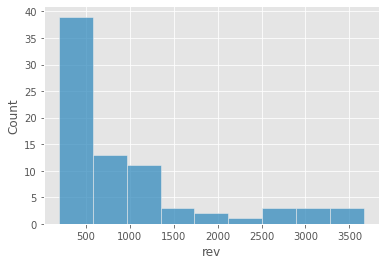

In [47]:
ax = sns.histplot(data=df.query('rev > 0 and grp == "A"'), x="rev")

Text(0.5, 1.0, 'Group B')

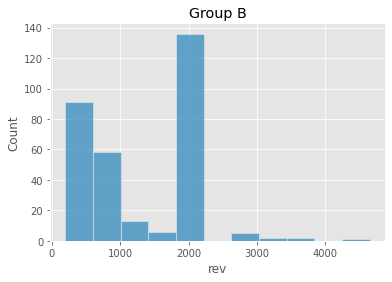

In [48]:
ax = sns.histplot(data=df.query('rev > 0 and grp == "B"'), x="rev")
ax.set_title('Group B')

Интересно, что на графике сразу же видно большое количество пользователей с оплатой в размере ~2000. Вопрос требует уточнения, особенно учитывая новую механику оплаты, вполне возможно, что произошел сбой либо при самой оплате, либо при сборе данных.

In [49]:
df.query('1800 < rev < 2100 and grp == "B"').shape[0]

134

Наличие выбросов:

In [50]:
df.query('rev > 0').groupby('grp', as_index=False).agg({'rev': 'describe'})

grp    rev                                                                 
       count         mean         std    min     25%     50%      75%     max
0   A   78.0   933.589744  919.932711  199.0  290.00   585.0  1114.75  3660.0
1   B  314.0  1257.878992  790.864254  199.0  511.75  1140.0  1900.00  4650.0

Вероятнее всего, имеются выбросы. Графически:

<AxesSubplot:xlabel='grp', ylabel='rev'>

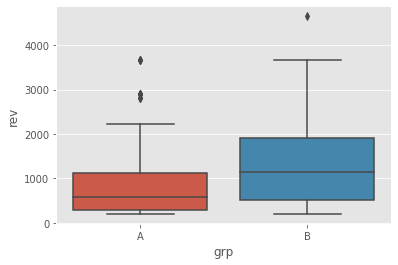

In [51]:
sns.boxplot(data=df.query('rev>0'), x='grp', y='rev')

Определяем гомогенность дисперсий при помощи теста Левена:

In [52]:
result = stats.levene(df.query('rev > 0 & grp == "A"').rev,
                      df.query('rev > 0 & grp == "B"').rev)

print(f'Тест Левена - p-value = {result.pvalue}: ')
if result.pvalue <= 0.05:
    print('отклоняем H0, дисперсии отличаются\n')
else:
    print('не отклоняем H0, дисперсии примерно одинаковы\n')

Тест Левена - p-value = 0.08025675761347022: 
не отклоняем H0, дисперсии примерно одинаковы



В итоге:

* размеры выборок отличаются
* обе выборки не имеют нормального распределения
* в обеих выборках есть выбросы
* дисперсии выборок примерно одинаковы

В данной ситуации можно было бы использовать t-тест, так как размер выборок достаточно большой, хотя и распределения не являются нормальными. Тест на гомоскедастичность показывает примерное равенство дисперсий, но все же имеет не очень высокий p-value, что в теории может повысить вероятность ошибки I рода, так что выберем другой метод.

Для данного случая можно применить U-критерий Манна-Уитни (непараметрический аналог t-критерия Стьюдента) или бутстрап. Остановимся на последнем, бутстрап проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев), а для критерия Манна-Уитни хотя и имеются допустимые для проведения теста выбросы в данных, но все же размер выборок существенно отличается.

Напишем функцию для бутстрап-анализа:

In [53]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2180.65it/s]


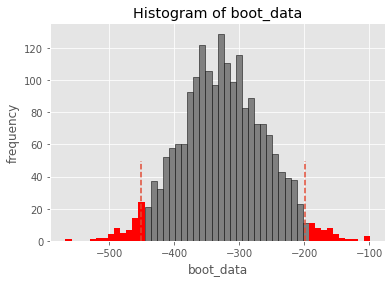

p-value = 8.225348568964743e-07
Отклоняем H0, средние значения контрольной и целевой группы отличаются


In [54]:
booted_data = get_bootstrap(df.query('rev > 0 & grp == "A"').rev,
                            df.query('rev > 0 & grp == "B"').rev)

print(f'p-value = {booted_data["p_value"]}')

prob = 0.95
alpha = 1.0 - prob
if booted_data["p_value"] <= alpha:
    print('Отклоняем H0, средние значения контрольной и целевой группы отличаются')
else:
    print('Не отклоняем H0, средние значения контрольной и целевой группы не отличаются')

В группе *В* увеличился средний чек по сравнению с группой *А* (изменения статистически значимы), следовательно, можно запускать новую механику на всех пользователей

## Добавление новых данных

Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла ```groups_add.csv``` и на основании дополнительных параметров пересчитывать метрики

In [ ]:
def get_metrics(path):
    
    '''
    Добавляет новую информацию. Так как мы проводим конкатенацию имеющегося файла с новым,
    то название заголовком не обязательно должно совпадать, главное, чтобы было одинаковое
    количество и последовательность расположения столбцов.
    
    '''
    #проверяем путь файла, если это ссылка на Яндекс.Диск, 
    #тогда применим тот же функционал, что ранее
    if 'https://disk.yandex.ru/' in path:
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        final_url = base_url + urlencode(dict(public_key = path)) 
        response = requests.get(final_url) 
        download_url = response.json()['href'] 
        groups_add = pd.read_csv(download_url)
    else:
        #если в качестве пути не ссылка, то сразу считываем
        groups_add = pd.read_csv(path) 
        
    # добавляем пользователей к уже имеющимся
    groups_all = pd.concat([groups, groups_add], axis=0)
    
    # отбираем тех, которые активные
    active_from_groups = groups_all.loc[groups_all.id.isin(active_studs.student_id)]
    
    #объединияем с данными об оплате
    checks.columns = ['id', 'rev']
    df = active_from_groups.merge(checks, how='left', on='id')
    
    # создаем датафрейм с метриками
    metrics = df.groupby('grp', as_index=False) \
                 .agg({'id': 'count'}) \
                 .merge(df.query('rev > 0') \
                          .groupby('grp', as_index=False) \
                          .agg({'id': 'count'}), on='grp') \
                 .rename(columns={'grp': 'group', 
                                  'id_x': 'users', 
                                  'id_y': 'purchases'})
    # считаем CR
    metrics['CR'] = metrics.purchases / metrics.users
    
    # считаем revenue
    revenue = df.groupby('grp', as_index=False) \
                .agg({'rev': 'sum'}) \
                .rename(columns={'grp': 'group', 
                                 'rev':'revenue'})

    metrics = metrics.merge(revenue, on='group')
  
    # считаем ARPPU и ARPAU
    metrics['ARPPU'] = (metrics.revenue / metrics.purchases).round(3)
    metrics['ARPAU'] = (metrics.CR * metrics.ARPPU).round(3)
    
    return metrics

Проверяем:

In [ ]:
get_metrics('https://disk.yandex.ru/d/3aARY-P9pfaksg')

,group,users,purchases,CR,revenue,ARPPU,ARPAU
0,A,1538,78,0.050715,72820.0000,933.590,47.347
1,B,6803,314,0.046156,394974.0035,1257.879,58.059


Дополнительно создадим функцию, которая будет строить графики по полученным метрикам

In [64]:
def get_plots(metrics):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 5))
    
    sns.barplot(x = metrics.group, 
                y = metrics.CR, 
                ax = ax[0]).set_title('CR')
    
    sns.barplot(x = metrics.group, 
                y = metrics.revenue, 
                ax = ax[1]).set_title('Revenue')
     
    sns.barplot(x = metrics.group,
                y = metrics.ARPPU, 
                ax = ax[2]).set_title('ARPPU')
    
    sns.barplot(x = metrics.group,
                y = metrics.ARPAU,
                ax = ax[3]).set_title('ARPAU')
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

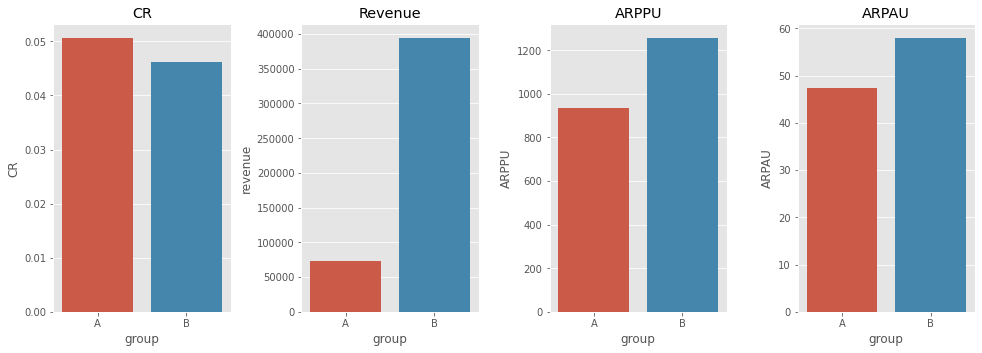

In [65]:
get_plots(metrics)